# Volume 3: Metropolis Algorithm
    <Name>
    <Class>
    <Date>

In [3]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis Hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma^2$. Use the given functions and Algorithm 1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Create plots resembling Figures 1 and 2:
 - Plot the log probabilities of the first 500 samples.
 - Plot the samples for $\mu$ in the order they were drawn, and likewise for $\sigma^2$.
 - Using `seaborn.kdeplot` plot the distribution of all samples for $\mu$, and likewise for $\sigma^2$.

Use $u=20$ for the parameter of the proposal function.
Use the initial state $\mathbf{y}_0=(\mu_0,\sigma^2_0)=(40,10)$.
Take 10,000 samples for both $\mu$ and $\sigma^2$. 

Compare your results with Figures 1 and 2.

In [7]:
def proposal(y, u):
    """Returns the proposal, i.e. a draw from Q(x,y) = N(x|y,uI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=u*np.eye(len(y)))

In [8]:
def propLogDensity(x, muprior, sig2prior, scores):
    """Calculate the log of the proportional density funciton f."""
    if x[1] <= 0:
        return -np.inf
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob

In [9]:
def acceptance(x, y, muprior, sig2prior, scores):
    """
    Returns the acceptance probability of moving from y to x.
    """
    return np.exp(min(0, 
                  propLogDensity(x, muprior, sig2prior, scores) 
                - propLogDensity(y, muprior, sig2prior, scores)
    ))

In [26]:
def metropolis(x0, u, n_samples, muprior, sig2prior, scores):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    draws = [x0]
    logprobs = []
    accepted = 0
    rejected = 0
    for t in range(n_samples):
        y = draws[-1]
        x = proposal(y, u)
        if np.random.uniform() <= acceptance(x, y, muprior, sig2prior, scores):
            draws.append(x)
            accepted += 1
        else:
            draws.append(y)
            rejected += 1
        logprobs.append(propLogDensity(draws[-1], muprior, sig2prior, scores))

    accept_rate = accepted / (accepted + rejected)
    return np.array(draws), np.array(logprobs), accept_rate


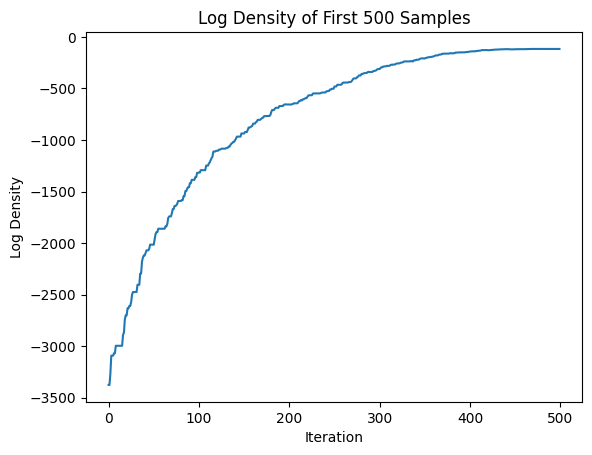

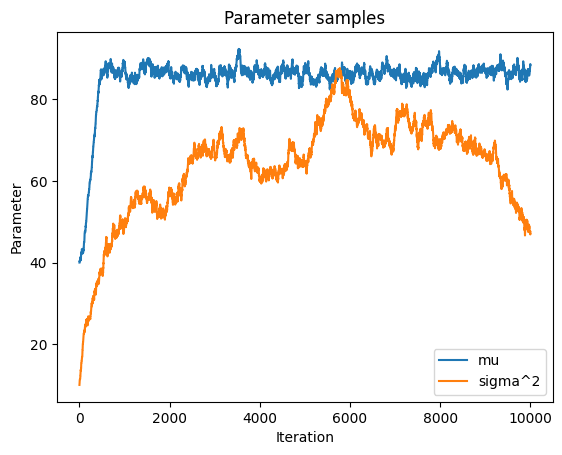

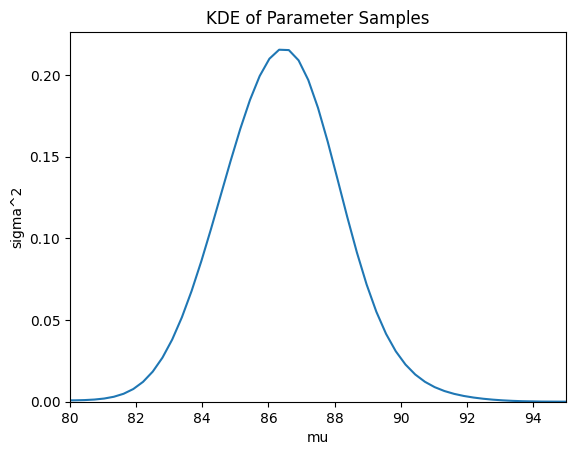

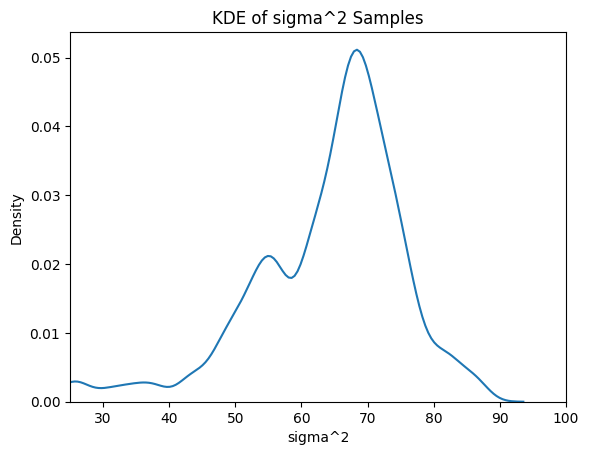

In [32]:
# Load in the data and initialize priors
scores = np.load("examscores.npy")

# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
sig2prior = stats.invgamma(alpha, scale=beta)

# Prior mu ~ N(m, s)
m = 80
s = 4
muprior = stats.norm(loc=m, scale=sqrt(s**2))

metro = metropolis(np.array([40, 10]), 0.1, 10000, muprior, sig2prior, scores)

# Plot the log probs for the first 500 samples
plt.plot(metro[1][:500])
plt.xlabel("Iteration")
plt.ylabel("Log Density")
plt.title("Log Density of First 500 Samples")
plt.show()

# Plot the parameter samples
plt.plot(metro[0])
plt.xlabel("Iteration")
plt.ylabel("Parameter")
plt.title("Parameter samples")
plt.legend(["mu", "sigma^2"])
plt.show()

# Plot the kdensity of the mu samples
sbn.kdeplot(metro[0][:,0])
plt.xlabel("mu")
plt.xlim(80, 95)
plt.ylabel("sigma^2")
plt.title("KDE of Parameter Samples")
plt.show()

# Plot the kdensity of the sigma^2 samples
sbn.kdeplot(metro[0][:,1])
plt.xlabel("sigma^2")
plt.xlim(25,100)
plt.ylabel("Density")
plt.title("KDE of sigma^2 Samples")
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [33]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [36]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    n = L.shape[0]
    energy = 0
    for i in range(n):
        for j in range(n):
            energy += -L[i,j]*(L[(i+1)%n,j] + L[i,(j+1)%n])
    return energy

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [43]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    return np.random.randint(0,n), np.random.randint(0,n-1)

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$ th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [39]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    n = L.shape[0]
    return L_energy + 2*L[i,j]*(L[(i-1)%n,j] + L[(i+1)%n,j] + L[i,(j-1)%n] + L[i,(j+1)%n])

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [45]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    if energy_new < energy_old:
        return True
    else:
        return np.log(np.random.uniform()) < beta*(energy_old - energy_new)

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [57]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    L = random_lattice(n)
    L_energy = lattice_energy(L)
    samples = []
    energies = []
    accepted = 0
    rejected = 0
    for t in range(n_samples + burn_in):
        energies.append(-L_energy)
        i, j = flip_location(n)
        new_energy = updated_energy(L, L_energy, i, j)
        if accept(beta, L_energy, new_energy):
            L[i,j] *= -1
            L_energy = new_energy
            accepted += 1
        else:
            rejected += 1
        if t >= burn_in and t % 100 == 0:
            samples.append(L.copy())
    return np.array(samples), np.array(energies), accepted / (accepted + rejected)

(200000,)


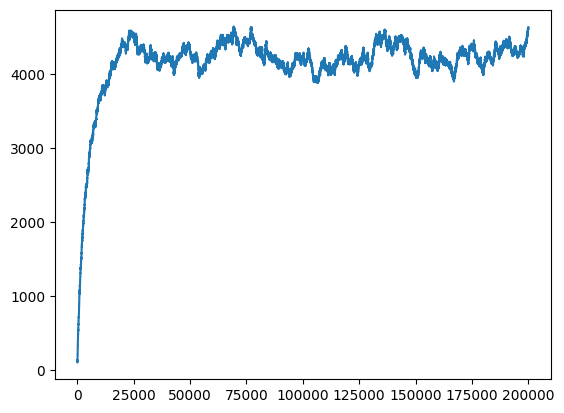

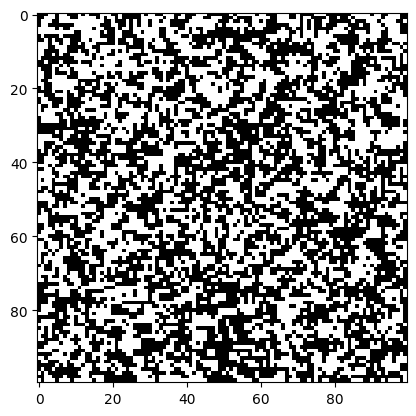

(200000,)


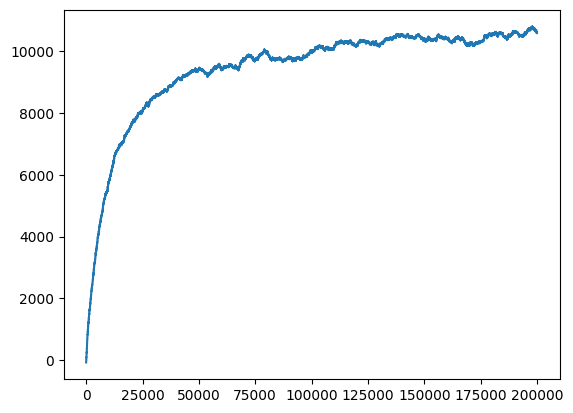

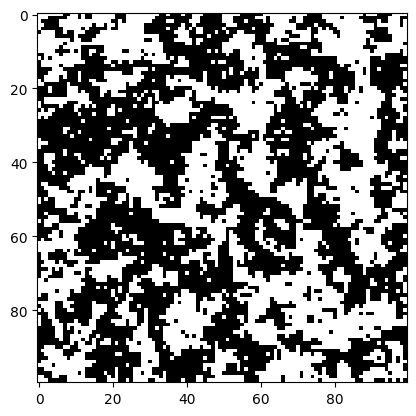

(200000,)


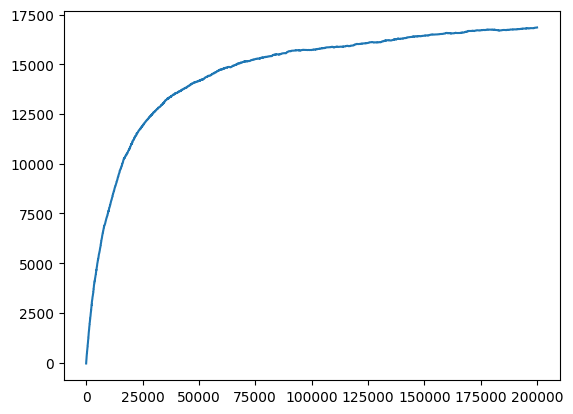

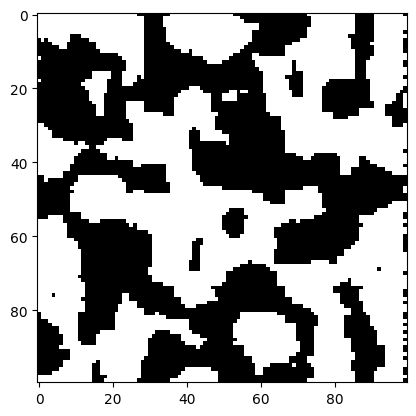

In [58]:
for beta in [0.2, 0.4, 1]:
    L = ising_metropolis(beta, 100, 5000, 195000)

    print(L[1].shape)

    # plot the log probs for all the samples
    plt.plot(L[1])
    plt.show()

    # Plot a sample from the lattice
    plt.imshow(L[0][0], cmap='gray')
    plt.show()